# Question 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_train_path = '/content/drive/MyDrive/data/train'
dataset_test_path = '/content/drive/MyDrive/data/test'

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
import tensorflow as tf
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras import backend as K
import cv2

I uploaded the data on my google drive and used tf.keras.preprocessing.image.ImageDataGenerator to load train, test and validation based on the name of the folders. I also load them in grayscale and normalized them.

In [4]:
image_size = (48, 48)
num_classes = 7
batch_size = 128
# extracting the pictures, preprocessing them and splitting them into train, validation and test groups.
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
# training
train_batches = train_datagen.flow_from_directory(
    dataset_train_path,
    target_size = image_size,
    color_mode='grayscale',
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)
# validation
validation_batches = train_datagen.flow_from_directory(
    dataset_train_path,
    target_size = image_size,
    color_mode='grayscale',
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)
# test
test_batches = test_datagen.flow_from_directory(
    dataset_test_path,
    target_size = image_size,
    color_mode='grayscale',
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


in this part I extracting that which integer number and which one hot coding display each labels.

In [ ]:
# Get the class indices
class_indices = train_batches.class_indices

# Define the labels for the image data
y_train = train_batches.classes

# Convert the labels to one-hot encoded vectors
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=num_classes)

# Map indices to class names
idx_to_class = {v: k for k, v in class_indices.items()}

# Find unique labels
unique_labels = np.unique(y_train)

# Print unique labels, class names, and one-hot encoded labels
for label in unique_labels:
    class_name = idx_to_class[label]
    one_hot_label = y_train_encoded[np.where(y_train == label)[0][0]]  # Get one-hot label for the first occurrence of the label
    print(f"Unique Label: {label}, Class Name: {class_name}, One-Hot Label: {one_hot_label}")


Unique Label: 0, Class Name: angry, One-Hot Label: [1. 0. 0. 0. 0. 0. 0.]
Unique Label: 1, Class Name: disgust, One-Hot Label: [0. 1. 0. 0. 0. 0. 0.]
Unique Label: 2, Class Name: fear, One-Hot Label: [0. 0. 1. 0. 0. 0. 0.]
Unique Label: 3, Class Name: happy, One-Hot Label: [0. 0. 0. 1. 0. 0. 0.]
Unique Label: 4, Class Name: neutral, One-Hot Label: [0. 0. 0. 0. 1. 0. 0.]
Unique Label: 5, Class Name: sad, One-Hot Label: [0. 0. 0. 0. 0. 1. 0.]
Unique Label: 6, Class Name: surprise, One-Hot Label: [0. 0. 0. 0. 0. 0. 1.]


## Training

training a model for this dataset took a realy long time. so I used different google accounts for every epoch. I used a callback called checkpoint to save the model after each epoch in google drive. so for the first epoch it is a bit different but for the other epochs I loaded the weights from the model after the last training, and continue training on that model.

### first epoch
run just one time.

In [ ]:
model = keras.Sequential()

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

checkpoint_filepath = '/content/drive/MyDrive/checkpoints/model_checkpoint.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_acc',
    mode='max',
    save_freq="epoch"
)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy','Recall','Precision'])

history = model.fit(train_batches,
          batch_size=batch_size,
          epochs=1,
          verbose=1,
          validation_data=validation_batches,
          callbacks=[model_checkpoint_callback])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 46, 46, 256)       2560      
                                                                 
 conv2d_21 (Conv2D)          (None, 44, 44, 512)       1180160   
                                                                 
 batch_normalization_16 (Ba  (None, 44, 44, 512)       2048      
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 22, 22, 512)       0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 22, 22, 512)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 256)      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 9781s 54s/step - loss: 1.8197 - accuracy: 0.2884 - recall: 0.0700 - precision: 0.4390 - val_loss: 1.8654 - val_accuracy: 0.2871 - val_recall: 0.0329 - val_precision: 0.5309


### next epochs

run multiple times.

In [ ]:
model = keras.Sequential()

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

checkpoint_filepath = '/content/drive/MyDrive/checkpoints/model_checkpoint.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_freq="epoch"
)

model.load_weights(checkpoint_filepath)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy','Recall','Precision'])

history = model.fit(train_batches,
          batch_size=batch_size,
          epochs=1,
          verbose=1,
          validation_data=validation_batches,
          callbacks=[model_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 512)       1180160   
                                                                 
 batch_normalization (Batch  (None, 44, 44, 512)       2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 512)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 256)       1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 5850s 32s/step - loss: 1.5079 - accuracy: 0.4116 - recall: 0.1851 - precision: 0.6936 - val_loss: 1.7915 - val_accuracy: 0.2672 - val_recall: 0.0183 - val_precision: 0.8400


In [ ]:
score = model.evaluate(test_batches, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test recall:', score[3])
print('Test precision:', score[4])

In [ ]:
model.save('model_HW2_2_3.h5')

### loading my best model


> https://drive.google.com/file/d/1AcYM5pBLjMwQ2msvFOjcbfmfBiAUoPTo/view?usp=drive_link



In [5]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/HW2_models/model_HW2_2_3.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 512)       1180160   
                                                                 
 batch_normalization (Batch  (None, 44, 44, 512)       2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 512)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 256)       1

## confusion matrix
I used predict module for the inputs for confusion matrix.

In [ ]:
# Get the true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Iterate over your data generator to get predictions
for i in range(len(test_batches)):
    batch_x, batch_y = test_batches[i]
    true_labels.extend(np.argmax(batch_y, axis=1))  # Assuming one-hot encoding for labels
    predicted_probs.extend(model.predict(batch_x))

# Convert predicted probabilities to class predictions
predicted_labels = np.argmax(predicted_probs, axis=1)

1/1 [==============================] - 1s 1s/step


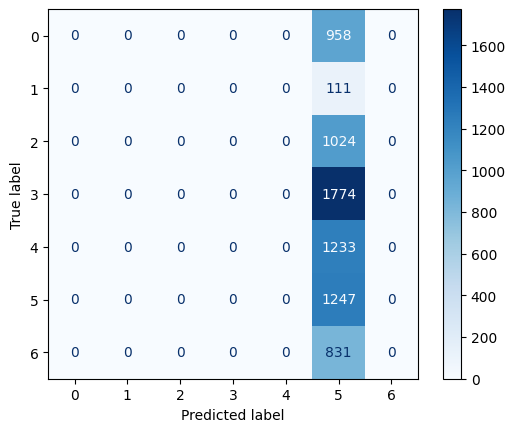

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## visualizing the filters

first I pick a picture from the dataset and plotted them. and then choose two filters from a layer ans also plotted them. after that I used the conv for applying the filters and seeing the result. it seems that these filters seperate the entire face.

In [32]:
# training
train_batches = train_datagen.flow_from_directory(
    dataset_train_path,
    target_size = image_size,
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

Found 22968 images belonging to 7 classes.


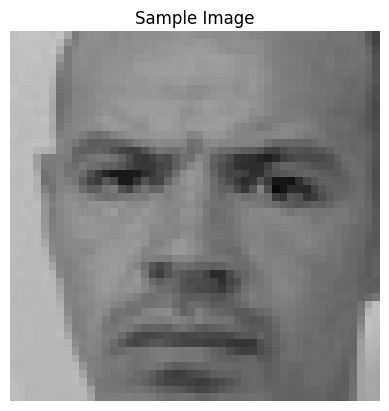

In [33]:
# Select one image from the batch
image = train_batches[1][0][100]

# Plot the selected image
plt.imshow(image)
plt.title('Sample Image')
plt.axis('off')
plt.show()

256
189


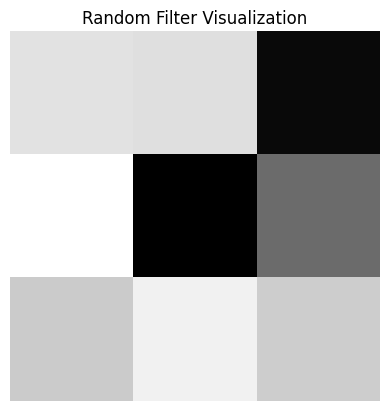

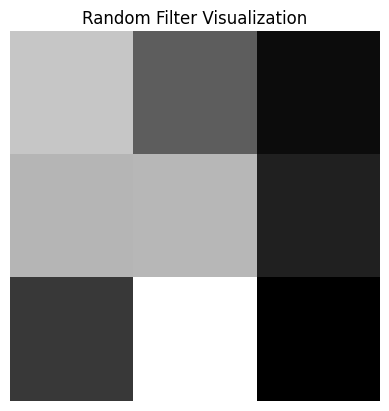

In [42]:
# Specify the index of the convolutional layer you want to visualize
layer_index1 = 0  # Change this to the index of the convolutional layer you're interested in

# Extract weights from the specified convolutional layer
layer1 = model.layers[layer_index1]
weights1 = layer1.get_weights()[0]

# Get the number of filters in the convolutional layer
num_filters1 = weights1.shape[3]
print(num_filters1)
# Randomly select a filter index
random_filter_index1 = np.random.randint(0, num_filters1)

# Extract the random filter from the weights tensor
random_filter1 = weights1[:, :, :, random_filter_index1-2:random_filter_index1]

filter_normalized1 = []
for i in range(0, 2):
    # Normalize the filter weights to the range [0, 1] for visualization
    filter_normalized1.append((random_filter1[:, :, :, i] - np.min(random_filter1[:, :, :, i])) / (np.max(random_filter1[:, :, :, i]) - np.min(random_filter1[:, :, :, i])))
    # Plot the random filter as an image
    plt.imshow(filter_normalized1[i][:, :, 0], cmap='gray')  # Assuming grayscale filters
    plt.title('Random Filter Visualization')
    plt.axis('off')
    plt.show()


In [43]:
print(filter_normalized1[0].shape)

(3, 3, 1)


In [28]:
print(image.shape)
print(np.expand_dims(image, axis=0).shape)
a = np.repeat(image, 3, axis=-1)
print(a.shape)
print(np.expand_dims(a, axis=0).shape)

(48, 48, 1)
(1, 48, 48, 1)
(48, 48, 3)
(1, 48, 48, 3)


(1, 3, 3, 1)
(1, 48, 48, 3)


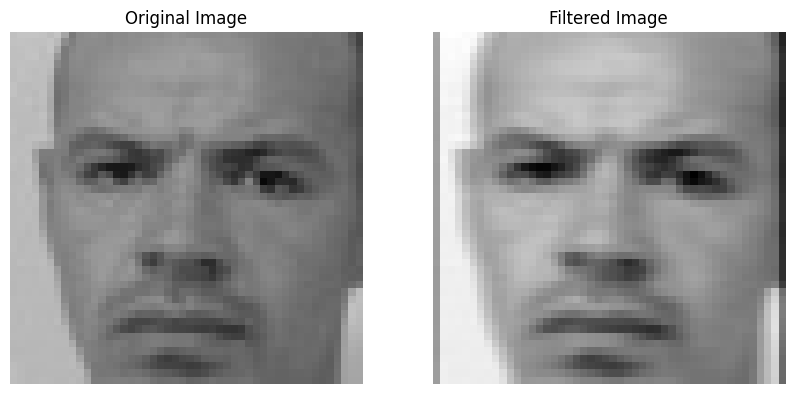

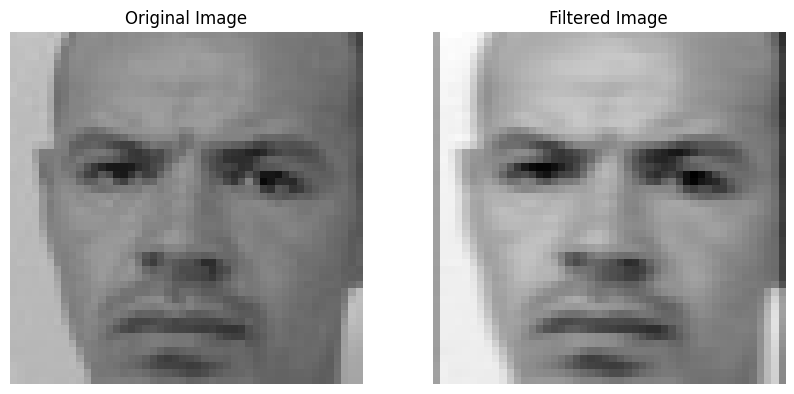

In [44]:
# Load an example image for testing
print(np.expand_dims(filter_normalized1[0], axis=0).shape)
print(np.expand_dims(image, axis=0).shape)

# Perform convolution between the image and the random filter
for i in range(0, len(filter_normalized1)):

    filtered_image = tf.nn.conv2d(np.expand_dims(image, axis=0), np.expand_dims(filter_normalized1[i], axis=0), strides=[1, 1, 1, 1], padding='SAME')

    # Plot the original image and the filtered image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(filtered_image), cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')

    plt.show()

## testing

my laptop doesn't have camera, I tried to use a cellphone as webcam but it did'nt work. so I tried to load some of my images to see it's prediction.

1/1 [==============================] - 0s 30ms/step
[[3.1885103e-37 0.0000000e+00 4.6198606e-16 1.0000000e+00 4.8833562e-26
  8.5226314e-26 9.1586568e-21]]


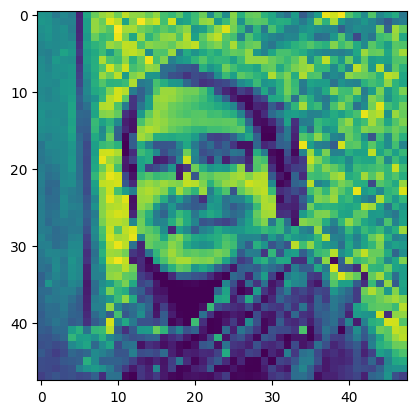

In [52]:
image1 = keras.utils.load_img('/content/image1.jpg', color_mode="grayscale", target_size=(48, 48))
input_arr = keras.utils.img_to_array(image1)
plt.imshow(image1)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
print(predictions)

1/1 [==============================] - 0s 41ms/step
[[2.2723158e-25 0.0000000e+00 5.2623700e-19 1.0000000e+00 6.1238034e-15
  6.5483634e-15 6.2737299e-25]]


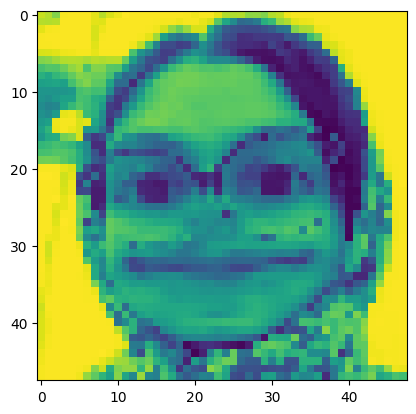

In [51]:
image2= keras.utils.load_img('/content/image2.jpg', color_mode="grayscale", target_size=(48, 48))
input_arr = keras.utils.img_to_array(image2)
plt.imshow(image2)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
print(predictions)